# Goal:

In this assignment, you will implement a [Classifier Free Guidance model](https://arxiv.org/pdf/2207.12598) class on MNIST dataset using PyTorch according to the guidence. The goal is to minimize the loss function and train the model to generate MNIST images with conditions on label.

The `Train` and `UNet` classes are already implemented for you. You need to implement the `CFGDiffusion` class (see details below). The images generated by the model will be automatically shown according to the `Trainer` class implementation. Make sure the generated images are shown in the output, it will be graded.

Grade:
- Explain why is the model called Classifier Free  and why Guidance (5 points).
- According to the paper, what would be an alternative of classifier free ? Explain how would the loss change in this alternative compared to the original DDPM loss ? (5 points)
- Implement CFGDiffusion class (20 points)
- Complete the Trainer.sample() method (10 points)
- Write a report to describe the sampled images generated by each epochs (5 points).

**Please note that the function to generate the images is already provided.**

---
Please DO NOT change the code provided, only add your own code where indicated. It is recommended that you **use CPU session to debug** when GPU is not necessary since Colab only gives 12 hrs of free GPU access at a time. If you use up the GPU resource, you may consider using Kaggle GPU resource. Thank you and good luck!

# Pre-determined config and given functions (no need to change)

In [1]:
try:
    from google.colab import drive
    drive.mount('/content/drive')
except:
    pass 

Add the following files to your directory:
- args.py
- unet.py
- datasets.py
- utils.py

In [1]:
import os

os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
import torch
import torch.utils.data
from torch import nn
from typing import Tuple, Optional
import torch.nn.functional as F
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch.amp import GradScaler, autocast

from cfg_utils.args import *
from cfg_utils.dataset import *
from cfg_utils.unet import *
os.environ["CUDA_VISIBLE_DEVICES"] = "3"


torch.cuda.set_device(3)
device = torch.device("cuda:3" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda:3


In [2]:
print(f"Using {args.device} backend")

Using cuda:3 backend


# Implement the Classifier Free Guidance Model 

To that end, refer to the training and sampling algorithms from the paper as well as the different equations. Less description is included here so that you're forced to learn how to refer to a paper. Still, note that guidences are also here to help you with what to fill in each function


In [3]:
class CFGDiffusion():
    def __init__(self, eps_model: nn.Module, n_steps: int, device: torch.device):
        super().__init__()
        self.eps_model = eps_model
        self.n_steps = n_steps
        self.device = device
        
        self.lambda_min = -20
        self.lambda_max = 20

    ### UTILS
    def get_exp_ratio(self, l: torch.Tensor, l_prim: torch.Tensor):
        return torch.exp(l-l_prim)
    
    def get_lambda(self, t: torch.Tensor): 
        # TODO: Write function that returns lambda_t for a specific time t. Do not forget that in the paper, lambda is built using u in [0,1]
        # Note: lambda_t must be of shape (batch_size, 1, 1, 1)
        u = t.float() / self.n_steps    
        b = torch.atan(torch.exp(-torch.tensor(self.lambda_max) / 2))
        a = torch.atan(torch.exp(-torch.tensor(self.lambda_min) / 2)) - b
        lambda_t = -2 * torch.log(torch.tan(a * u + b))
        lambda_t = lambda_t.reshape(-1,1,1,1)
        return lambda_t
    
    def alpha_lambda(self, lambda_t: torch.Tensor): 
        #TODO: Write function that returns Alpha(lambda_t) for a specific time t according to (1)
        alpha = 1/(1+torch.exp(-lambda_t))

        return alpha.sqrt()
    
    def sigma_lambda(self, lambda_t: torch.Tensor): 
        #TODO: Write function that returns Sigma(lambda_t) for a specific time t according to (1)
        alpha = self.alpha_lambda(lambda_t)
        sigma = 1-alpha.pow(2)

        return sigma.sqrt()
    
    
    ## Forward sampling
    def q_sample(self, x: torch.Tensor, lambda_t: torch.Tensor, noise: torch.Tensor):
        #TODO: Write function that returns z_lambda of the forward process, for a specific: x, lambda l and N(0,1) noise  according to (1)
        alpha_lam = self.alpha_lambda(lambda_t)
        sigma_lam = self.sigma_lambda(lambda_t)

        sample = alpha_lam*x + sigma_lam*noise

        return sample
    def sigma_q(self, lambda_t: torch.Tensor, lambda_t_prim: torch.Tensor):
        #TODO: Write function that returns variance of the forward process transition distribution q(•|z_l) according to (2)
        sigma_lambda_t = self.sigma_lambda(lambda_t)
        sigma_ratio = (1-self.get_exp_ratio(lambda_t,lambda_t_prim))*sigma_lambda_t.pow(2)

        return sigma_ratio.sqrt()
    
    def sigma_q_x(self, lambda_t: torch.Tensor, lambda_t_prim: torch.Tensor):
        #TODO: Write function that returns variance of the forward process transition distribution q(•|z_l, x) according to (3)
        sigma_lambda_t = self.sigma_lambda(lambda_t_prim)
        sigma_ratio = (1-self.get_exp_ratio(lambda_t,lambda_t_prim))*sigma_lambda_t.pow(2)

    
        return sigma_ratio.sqrt()


    ### REVERSE SAMPLING
    def mu_p_theta(self, z_lambda_t: torch.Tensor, x: torch.Tensor, lambda_t: torch.Tensor, lambda_t_prim: torch.Tensor):
        #TODO: Write function that returns mean of the forward process transition distribution according to (4)

        ratio = torch.exp(lambda_t - lambda_t_prim)
        mu = ratio*(self.alpha_lambda(lambda_t_prim)/self.alpha_lambda(lambda_t))*z_lambda_t + ((1-ratio)*self.alpha_lambda(lambda_t_prim)*x)

        return mu

    def var_p_theta(self, lambda_t: torch.Tensor, lambda_t_prim: torch.Tensor, v: float=0.3):
        #TODO: Write function that returns var of the forward process transition distribution according to (4)

        sigma_lambda = self.sigma_q(lambda_t,lambda_t_prim).pow(2)
        sigma_lambda_prim = self.sigma_q_x(lambda_t,lambda_t_prim).pow(2)

        var = (sigma_lambda_prim.pow(1-v))*(sigma_lambda.pow(v))

        return var
    
    def p_sample(self, z_lambda_t: torch.Tensor, lambda_t : torch.Tensor, lambda_t_prim: torch.Tensor,  x_t: torch.Tensor, set_seed=False):
        # TODO: Write a function that sample z_{lambda_t_prim} from p_theta(•|z_lambda_t) according to (4) 
        # Note that x_t correspond to x_theta(z_lambda_t)
        if set_seed:
            torch.manual_seed(42)
        
        sample = self.mu_p_theta(z_lambda_t,x_t,lambda_t,lambda_t_prim) + torch.sqrt(self.var_p_theta(lambda_t,lambda_t_prim))*torch.randn_like(x_t)
        return sample 

    ### LOSS
    def loss(self, x0: torch.Tensor, labels: torch.Tensor, noise: Optional[torch.Tensor] = None, set_seed=False):
        if set_seed:
            torch.manual_seed(42)
        batch_size = x0.shape[0]
        dim = list(range(1, x0.ndim))
        t = torch.randint(
            0, self.n_steps, (batch_size,), device=x0.device, dtype=torch.long
        )
        if noise is None:
            noise = torch.randn_like(x0)
        lambda_t = self.get_lambda(t)

        z_t = self.q_sample(x0, lambda_t, noise)


        self.eps_model.to(self.device)
        eps_prediction = self.eps_model(z_t, labels)

        loss = (eps_prediction - noise).pow(2).view(batch_size, -1).sum(dim=1).mean()
        
        return loss


    

# Finish implementation of the Trainer.sample() method

In [4]:
import copy 
import numpy as np 
from q3_trainer_cfg import * 

class Trainer:
    def __init__(self, args, eps_model, diffusion_model):

        self.eps_model = eps_model.to(args.device)

        self.diffusion = diffusion_model

        self.optimizer = torch.optim.Adam(
            self.eps_model.parameters(), lr=args.learning_rate
        )
        self.args = args
        self.current_epoch = 0

        self.ema = EMA(0.995)
        self.ema_model = copy.deepcopy(self.eps_model).eval().requires_grad_(False)


    def train_epoch(self, dataloader, scaler):
        current_lr = round(self.optimizer.param_groups[0]['lr'], 8)
        i = 0
        running_loss = 0.
        with tqdm(range(len(dataloader)), desc=f'Epoch : - lr: - Loss :') as progress:
            for x0, labels in dataloader:
                i += 1
                # Move data to device
                x0 = x0.to(self.args.device)
                # Use guidance
                labels = labels.to(self.args.device)
                if np.random.random() < 0.1:
                    labels = None

                # Calculate the loss
                with autocast(device_type=self.args.device, enabled=self.args.fp16_precision):
                    loss = self.diffusion.loss(x0, labels)
                    
                # Zero gradients
                self.optimizer.zero_grad()
                # Backward pass
                scaler.scale(loss).backward()
                scaler.step(self.optimizer)
                scaler.update()
                self.ema.step_ema(self.ema_model, self.eps_model)

                running_loss += loss.item()

                self.loss_per_iter.append(running_loss / i)
                progress.update()
                progress.set_description(f'Epoch: {self.current_epoch}/{self.args.epochs} - lr: {current_lr} - Loss: {round(running_loss / i, 2)}')
            progress.set_description(f'Epoch: {self.current_epoch}/{self.args.epochs} - lr: {current_lr} - Loss: {round(running_loss / len(dataloader), 2)}')

            # Step the scheduler after each epoch
            self.scheduler.step()

    def train(self, dataloader):
            scaler = GradScaler(device=self.args.device, enabled=self.args.fp16_precision)
            self.scheduler = torch.optim.lr_scheduler.StepLR(self.optimizer, step_size=5, gamma=0.5)
            start_epoch = self.current_epoch
            self.loss_per_iter = []
            for current_epoch in range(start_epoch, self.args.epochs):
                self.current_epoch = current_epoch
                self.train_epoch(dataloader, scaler)
                if current_epoch % self.args.show_every_n_epochs == 0:
                    self.sample(cfg_scale=self.args.cfg_scale)

                if (current_epoch + 1) % self.args.save_every_n_epochs == 0:
                    self.save_model()
    
    def sample(self, labels=None, cfg_scale=3., n_steps=None, set_seed=False):
        if set_seed:
            torch.manual_seed(42)
        if n_steps is None:
            n_steps = self.args.n_steps
            
        self.eps_model.eval()
            
        with torch.no_grad():
    
            z_t = torch.randn(
                        [
                            self.args.n_samples,
                            self.args.image_channels,
                            self.args.image_size,
                            self.args.image_size,
                        ],
                        device=self.args.device
                    )
            
            if labels == None:
                labels = torch.randint(0, 9, (self.args.n_samples,), device=self.args.device)
                
            if self.args.nb_save is not None:
                saving_steps = [self.args["n_steps"] - 1]
            
            # Remove noise for $T$ steps
            for t_ in tqdm(range(n_steps)):
            
                t = n_steps - t_ - 1
                t = torch.full((self.args.n_samples,), t, device=z_t.device, dtype=torch.long)
                
                #TODO: Get lambda and lambda prim based on t 
                lambda_t = self.diffusion.get_lambda(t)
                t_prev        = torch.clamp(t - 1, min=0)           
                lambda_t_prim = self.diffusion.get_lambda(t_prev)

                
                #TODO: Add linear interpolation between unconditional and conditional preidiction according to 3 in Algo. 2 using cfg_scale
    
                eps_uncond = self.eps_model(z_t, None)
                eps_cond   = self.eps_model(z_t, labels)
                eps_guided = (1 + cfg_scale) * eps_cond - cfg_scale * eps_uncond
                    
                #TODO: Get x_t then sample z_t from the reverse process according to 4. and 5. in Algo 2.

                alpha_t = self.diffusion.alpha_lambda(lambda_t)
                sigma_t = self.diffusion.sigma_lambda(lambda_t)
                x_t = (z_t - sigma_t * eps_guided) / alpha_t

                z_t = self.diffusion.p_sample(
                z_lambda_t=z_t,
                lambda_t=lambda_t,
                lambda_t_prim=lambda_t_prim,
                x_t=x_t,
                
                )

                if self.args.nb_save is not None and t_ in saving_steps:
                    print(f"Showing/saving samples from epoch {self.current_epoch} with labels: {labels.tolist()}")
                    show_save(
                        x_t,
                        labels,
                        show=True,
                        save=True,
                        file_name=f"DDPM_epoch_{self.current_epoch}_sample_{t_}.png",
                    )
            self.eps_model.train()
        return x_t

    def save_model(self):
        torch.save({
                'epoch': self.current_epoch,
                'model_state_dict': self.eps_model.state_dict(),
                'optimizer_state_dict': self.optimizer.state_dict(),
                }, self.args.MODEL_PATH)
    
def show_save(img_tensor, labels=None, show=True, save=True, file_name="sample.png"):
    fig, axs = plt.subplots(3, 3, figsize=(10, 10))  # Create a 4x4 grid of subplots
    assert img_tensor.shape[0] >= 9, "Number of images should be at least 9"
    img_tensor = img_tensor[:9]
    for i, ax in enumerate(axs.flat):
        # Remove the channel dimension and convert to numpy
        img = img_tensor[i].squeeze().cpu().numpy()
        label = labels[i].item()
        ax.imshow(img, cmap="gray")  # Display the image in grayscale
        ax.set_title(f'Digit:{label}')
        ax.axis("off")  # Hide the axis

    plt.tight_layout()
    if save:
        plt.savefig(f'./cfg_ddpm/{file_name}')
    if show:
        plt.show()
    plt.close(fig)

Epoch : - lr: - Loss ::   0%|          | 0/234 [00:00<?, ?it/s]

 99%|█████████▉| 994/1000 [00:14<00:00, 70.87it/s]

Showing/saving samples from epoch 0 with labels: [8, 0, 6, 7, 4, 5, 0, 7, 4, 3, 8, 7, 7, 8, 8, 8]


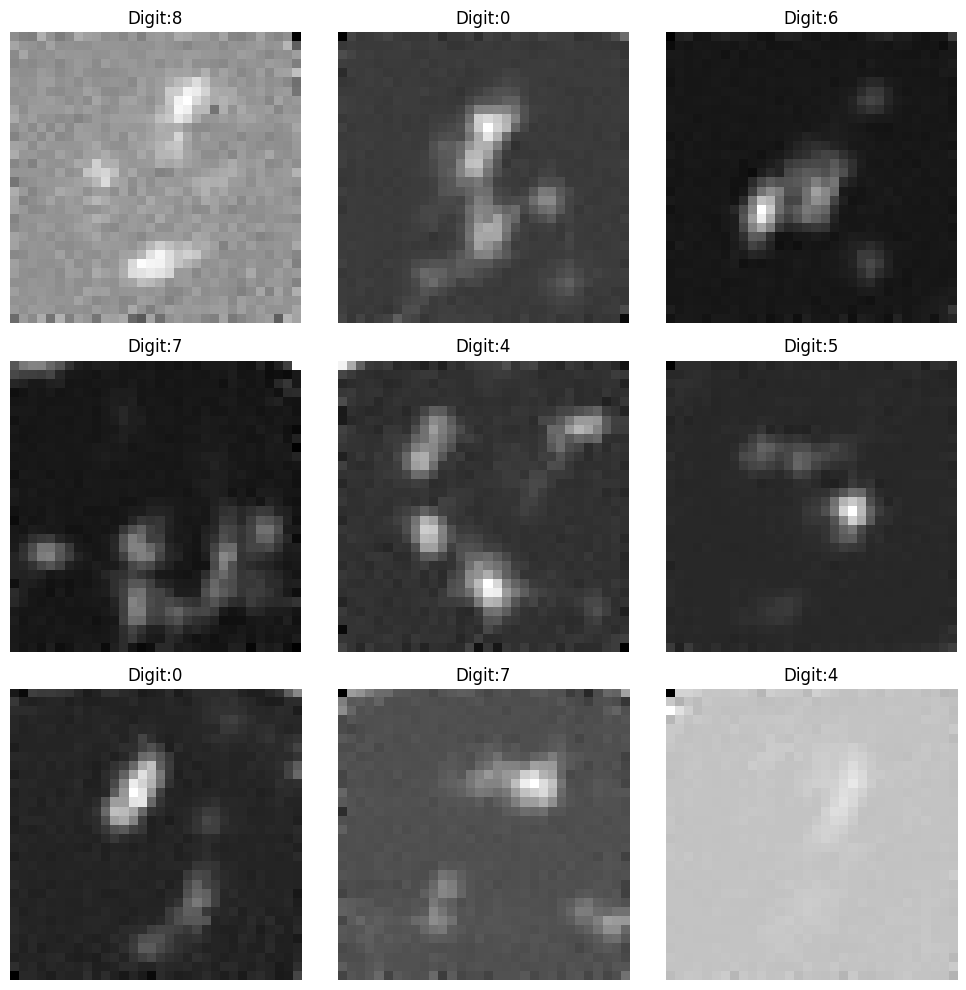

100%|█████████▉| 997/1000 [00:14<00:00, 69.94it/s]

Showing/saving samples from epoch 2 with labels: [0, 5, 7, 3, 4, 6, 2, 5, 6, 5, 0, 7, 4, 4, 6, 7]


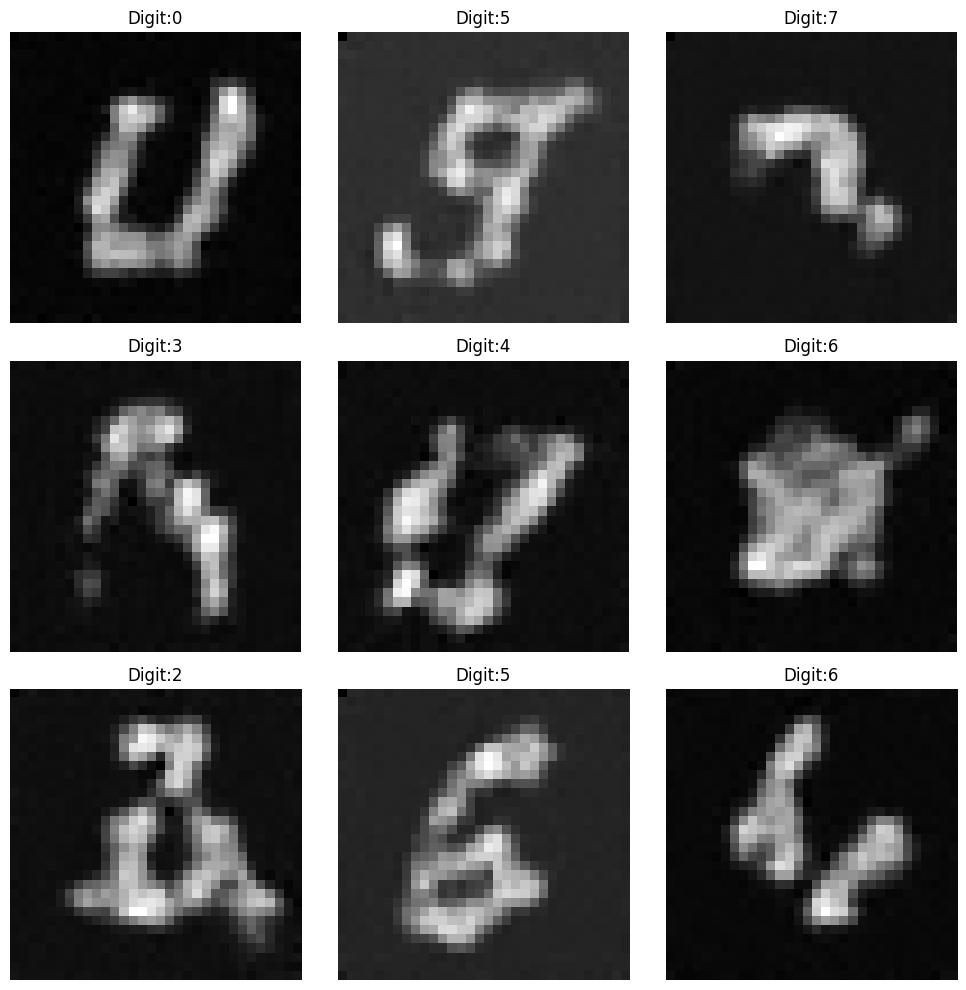

 99%|█████████▉| 992/1000 [00:14<00:00, 69.88it/s]

Showing/saving samples from epoch 4 with labels: [7, 8, 4, 7, 6, 4, 8, 5, 6, 3, 5, 3, 2, 8, 0, 2]


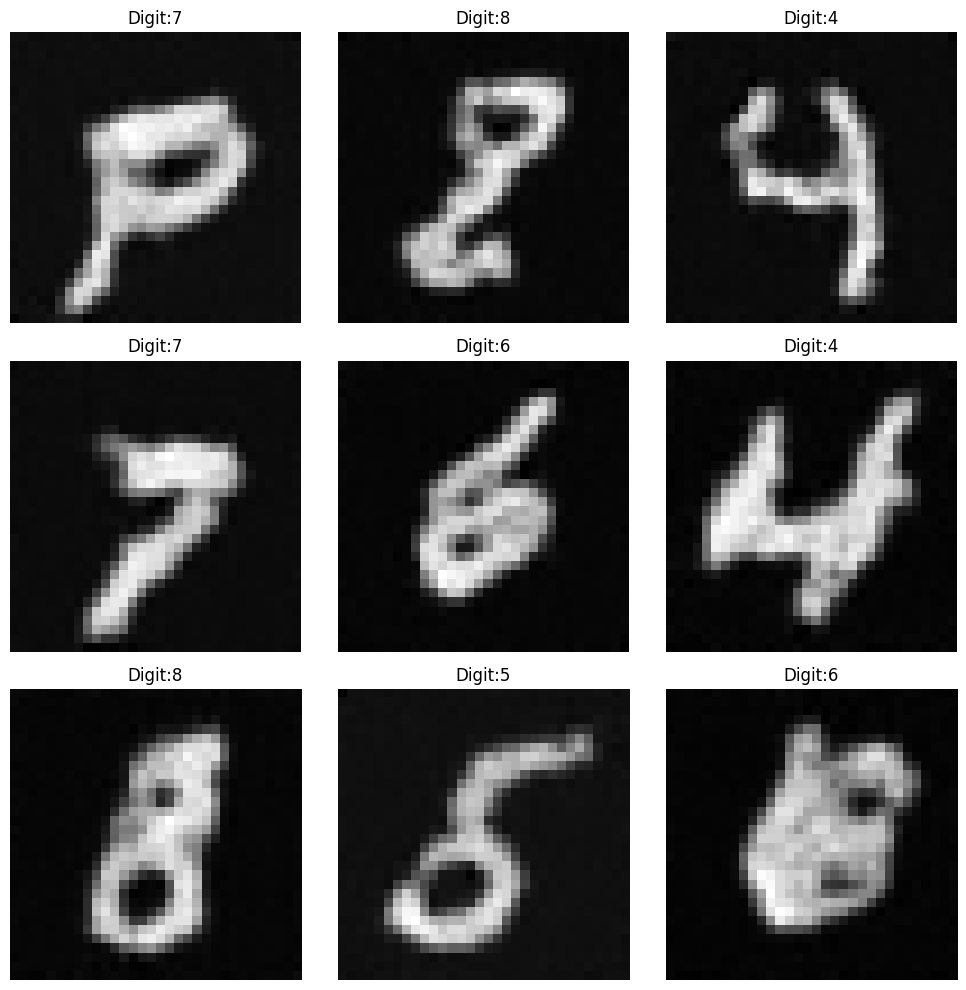

100%|█████████▉| 999/1000 [00:14<00:00, 70.86it/s]

Showing/saving samples from epoch 6 with labels: [1, 4, 1, 2, 5, 0, 2, 7, 5, 2, 7, 3, 4, 7, 7, 8]


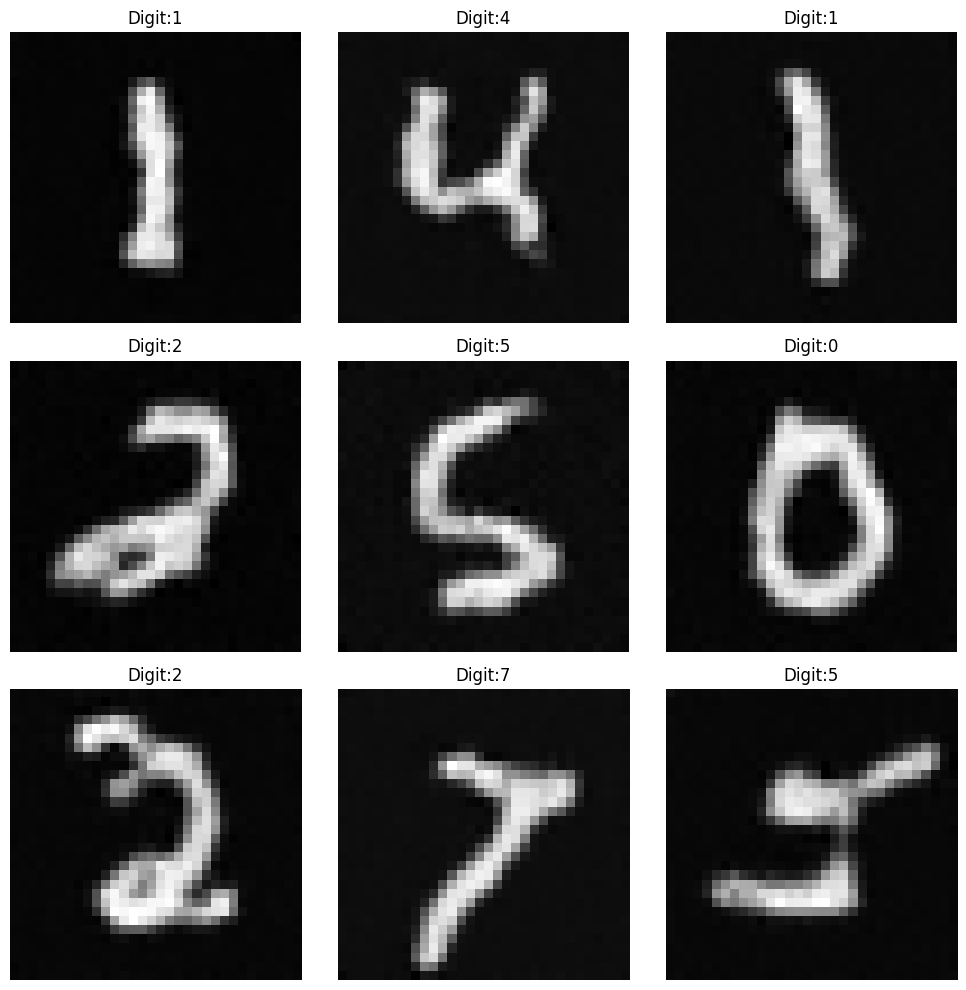

100%|█████████▉| 996/1000 [00:14<00:00, 70.72it/s]

Showing/saving samples from epoch 8 with labels: [2, 4, 6, 2, 4, 6, 5, 3, 6, 6, 4, 4, 6, 5, 2, 7]


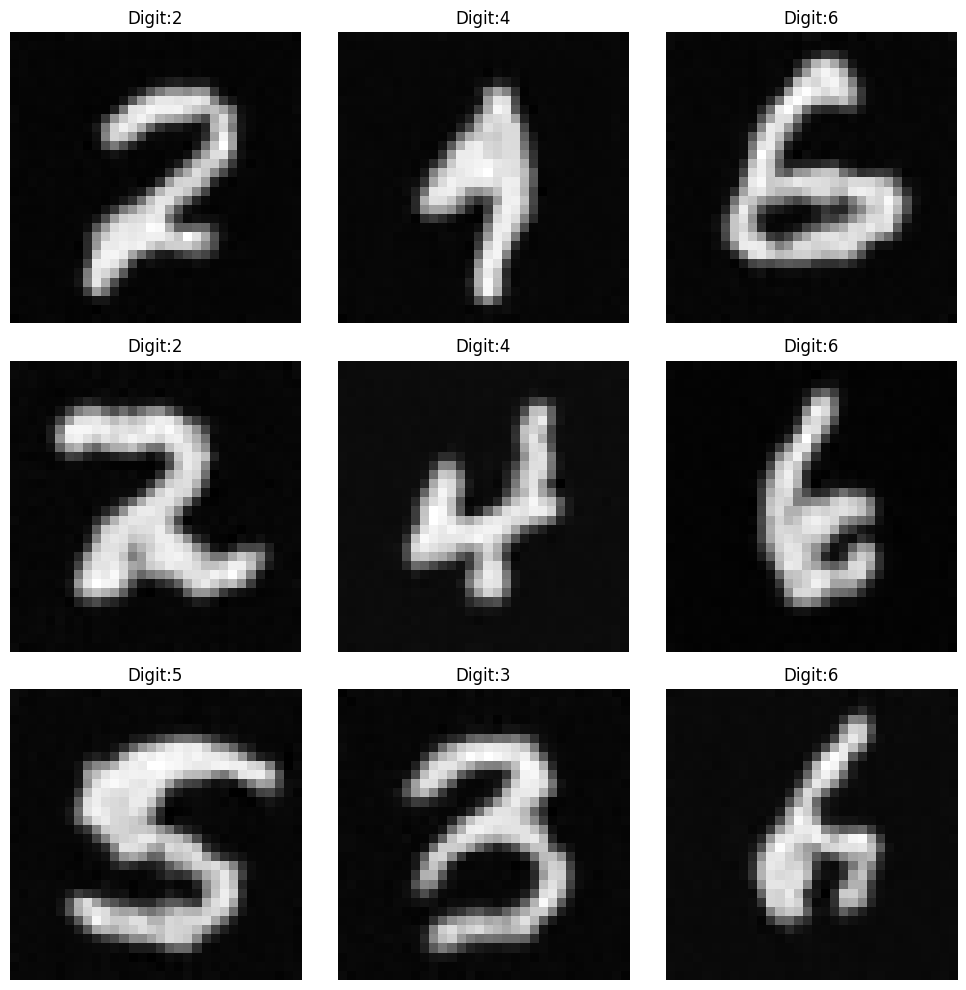

100%|█████████▉| 998/1000 [00:14<00:00, 70.47it/s]

Showing/saving samples from epoch 10 with labels: [0, 4, 7, 7, 6, 8, 5, 6, 4, 6, 1, 4, 1, 3, 2, 7]


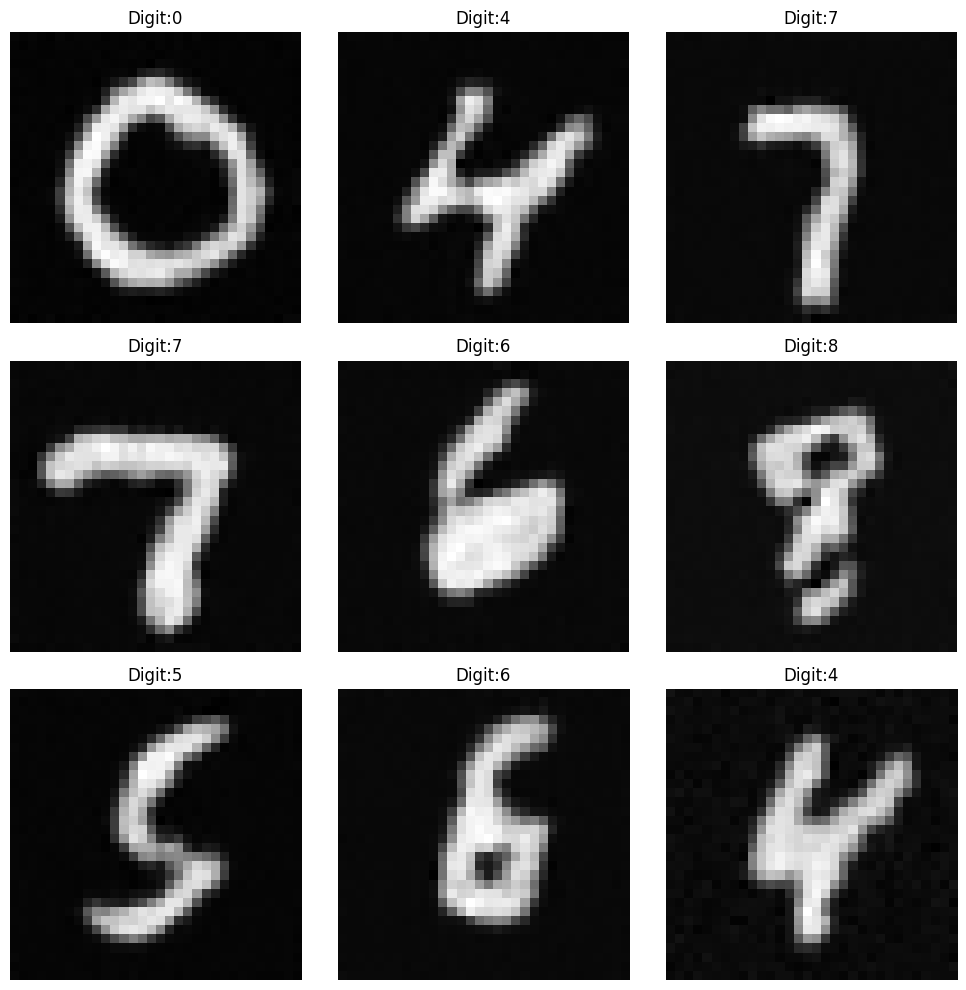

 99%|█████████▉| 992/1000 [00:14<00:00, 70.67it/s]

Showing/saving samples from epoch 12 with labels: [0, 1, 8, 4, 1, 5, 2, 2, 4, 6, 5, 7, 3, 8, 1, 3]


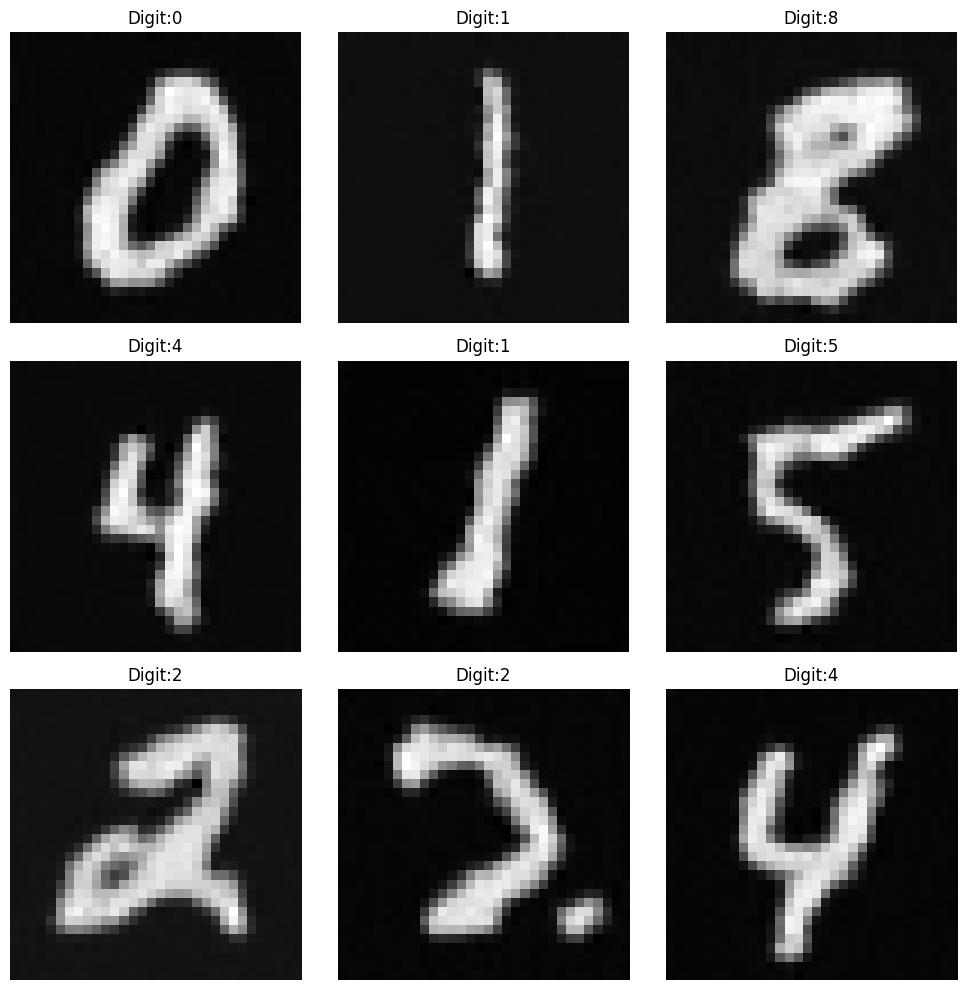

100%|█████████▉| 995/1000 [00:14<00:00, 70.85it/s]

Showing/saving samples from epoch 14 with labels: [8, 3, 6, 4, 6, 3, 3, 6, 1, 1, 2, 4, 0, 7, 7, 4]


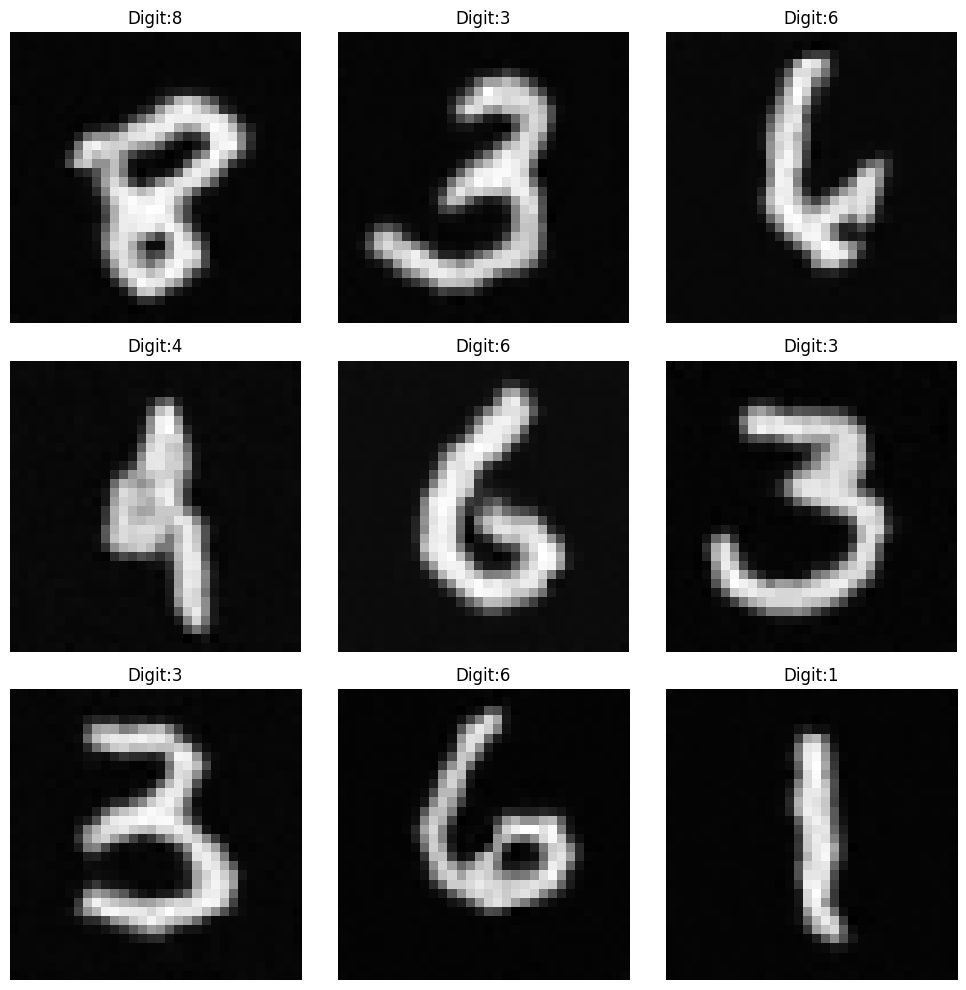

 99%|█████████▉| 994/1000 [00:14<00:00, 70.88it/s]

Showing/saving samples from epoch 16 with labels: [7, 4, 3, 8, 6, 4, 7, 6, 8, 3, 3, 1, 2, 5, 2, 0]


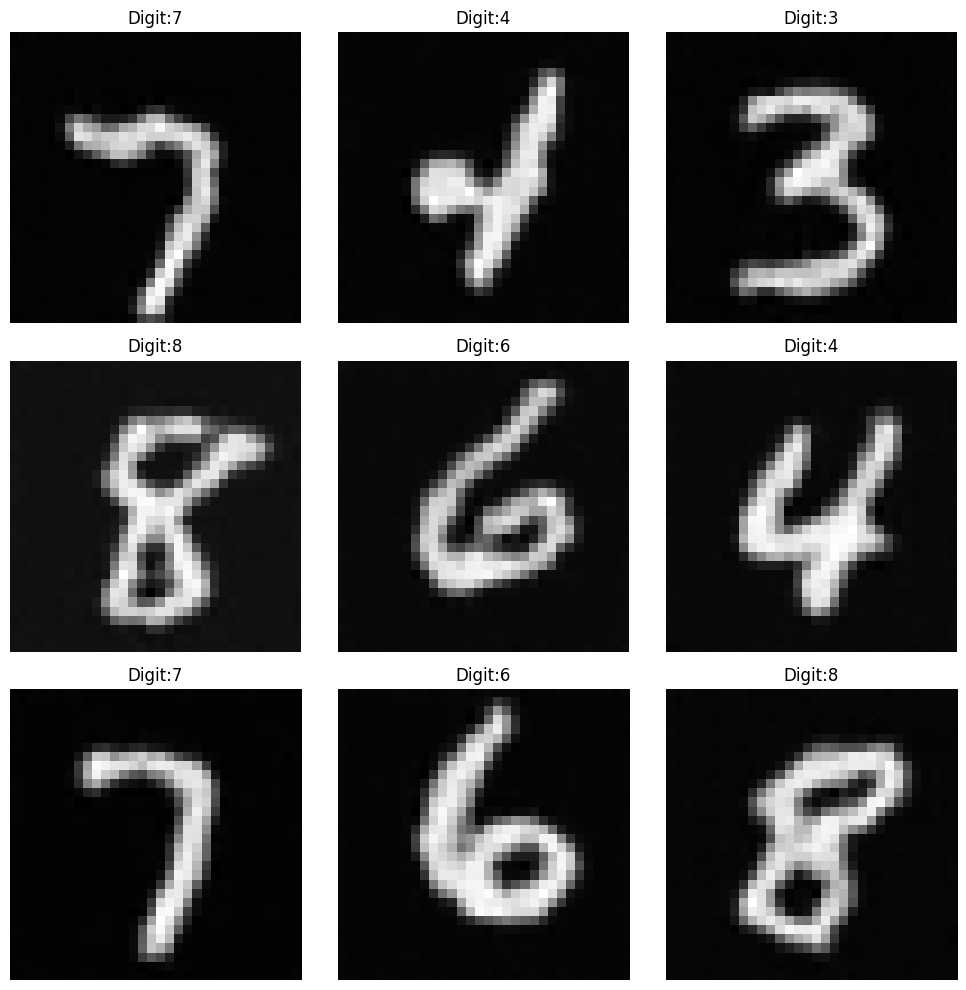

100%|█████████▉| 996/1000 [00:14<00:00, 69.68it/s]

Showing/saving samples from epoch 18 with labels: [8, 7, 7, 8, 8, 4, 7, 4, 5, 6, 5, 5, 6, 2, 5, 3]


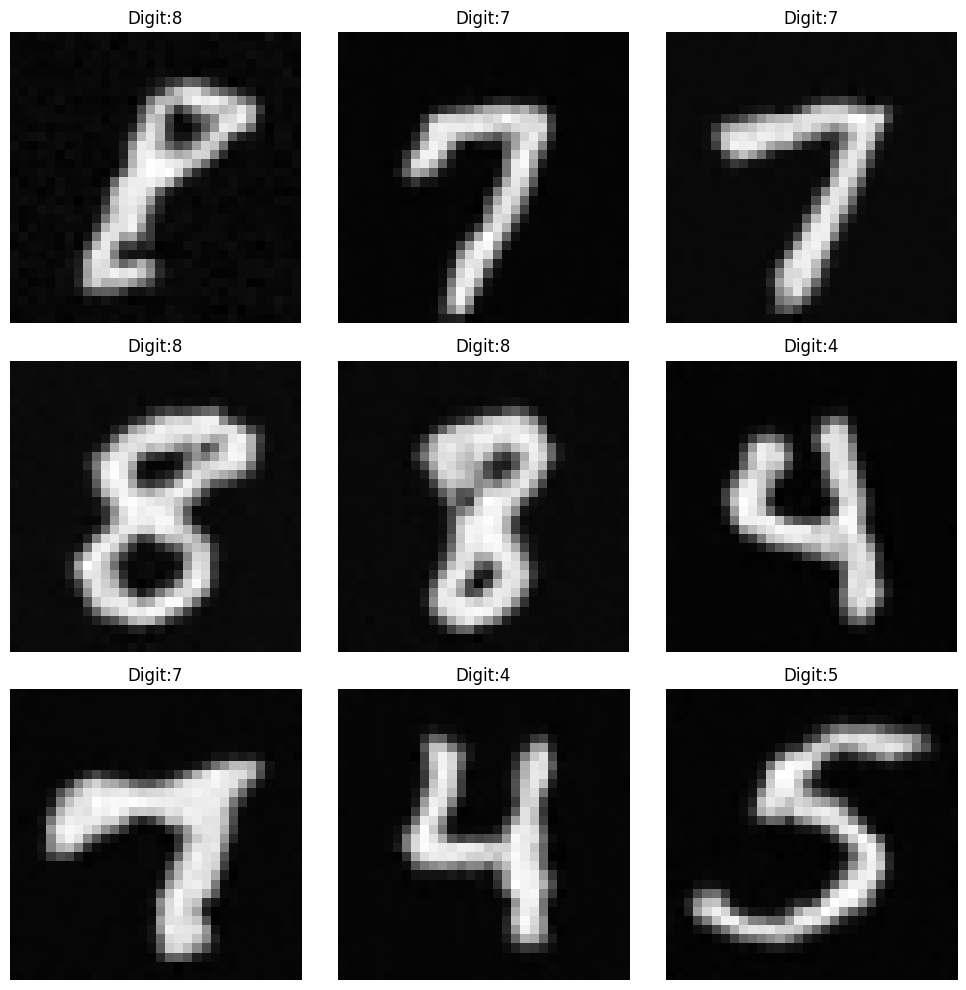

Epoch: 19/20 - lr: 2.5e-05 - Loss: 32.08: 100%|██████████| 234/234 [00:20<00:00, 11.40it/s]


In [5]:
# %%

dataloader = torch.utils.data.DataLoader(
    MNISTDataset(),
    batch_size=args.batch_size,
    shuffle=True,
    drop_last=True,
    num_workers=0,
    pin_memory=True,
)

eps_model = UNet_conditional(c_in=1, c_out=1, num_classes=10)

diffusion_model = CFGDiffusion(
            eps_model=eps_model,
            n_steps=args.n_steps,
            device=args.device,
        )

trainer = Trainer(args, eps_model, diffusion_model)

trainer.train(dataloader)